<a href="https://colab.research.google.com/github/AvivBGU/DeepLearning_Assignment2/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODOS:
1. Create a proper training setup and embed the stuff implemented in the data loaded to the relevant functions.
2. Make sure that loss and iterations, as well as general data is printed.
3. Have a testing setup for an arbitrary model.
4. Create a model factory to properly balance different parameters of the network.
5. Make sure that the testing setup allows the display of images to have visual verifacation.

# Imports & Constants

<font size="4">Imports </font>

In [1]:
import torch
import os
import torch.nn as nn
import zipfile
import requests
from glob import glob
from PIL import Image
import numpy as np
import torch.utils.data as data

print("Using torch", torch.__version__)

Using torch 2.6.0+cu124


<font size="4">Constants</font>

In [2]:
current_working_directory = os.getcwd()
DATA_BASE_DIRECTORY: str = os.path.join(current_working_directory, 'data')
TRAINING_SET_URL='https://web.archive.org/web/20241214060505/https://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt'
TEST_SET_URL='https://web.archive.org/web/20241214070147/https://vis-www.cs.umass.edu/lfw/pairsDevTest.txt#expand'
MAX_PIXEL_VALUE: float = 255.0
IMAGE_SIZE: tuple[int, int] = (250, 250)
BATCH_SIZE: int = 8
IMAGE_MODE: str = 'L' # If the image is greyscale
DEVICE_TO_USE: str = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {DEVICE_TO_USE}')

Using device: cuda


# Acquiring & Handling Data

<font size="6">Acquiring_Data</font>

In [3]:
!pip install -q gdown

def download_images_from_drive(file_id: str, zip_path: str) -> str:
  """
  Downloads images from drive and return the path to the extracted folder, but 1
  level down assuming the structure of the directories are known in advance.
  """
  file_location: str = os.path.join(DATA_BASE_DIRECTORY, 'lfw2', 'lfw2')
  if os.path.exists(file_location):
    print(f"Dataset already downloaded to {file_location}")
    return file_location
  !gdown {file_id} -O {zip_path}

  os.makedirs(DATA_BASE_DIRECTORY, exist_ok=True)
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(DATA_BASE_DIRECTORY)
  !rm {zip_path}
  print(f"Dataset extracted to {DATA_BASE_DIRECTORY}")
  return file_location

updated_dir_location: str = download_images_from_drive(
    file_id="1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp",
    zip_path="dataset.zip"
    )

Downloading...
From (original): https://drive.google.com/uc?id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp
From (redirected): https://drive.google.com/uc?id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp&confirm=t&uuid=e5afd55b-90b2-4db2-ad6b-721f0a291c20
To: /content/dataset.zip
100% 104M/104M [00:02<00:00, 44.6MB/s] 
Dataset extracted to /content/data


<font size="4">Preprocessing function</font>

<font size="4">Loading file paths to memory</font>

In [4]:
def loads_files_paths_to_memory(base_directory: str, image_format: str = '.jpg') -> None:
    images: dict[str, dict[int, str]] = dict()
    images_loaded: int = 0
    for root, subdirs, files in os.walk(base_directory):
        if root == base_directory:
            continue
        person_name: str = root.split(os.sep)[-1]
        if person_name not in images:
            images[person_name] = dict()
        for file in files:
            if not file.endswith(image_format):
                raise Warning(f"File {file} is not a {image_format} file. Continuing...")
                continue
            stripped_image: str = file.rstrip(image_format) # File without ending
            image_index: int = int(stripped_image.split('_')[-1])
            if image_index in images[person_name]:
                 raise ValueError(f"Index: {image_index} collision for: {person_name}")
            images[person_name][image_index] = os.path.join(root, file)
            images_loaded += 1
    if len(images) < 1:
        raise ValueError(f"No images were found in {base_directory}, aborting...")
    print(f"People scanned: {len(images)}")
    print(f"Images loaded: {images_loaded}")
    return images

loaded_images: dict[str, dict[str, str]] = loads_files_paths_to_memory(updated_dir_location)

People scanned: 5749
Images loaded: 13233


<font size="4">Organizing According to train-test</font>

Get train-test division and parse it.

In [5]:
def parse_train_test_txt(url_to_use: str):
    url_response = requests.get(url_to_use)
    if url_response.status_code == 200:
        text_content = url_response.text
    else:
        raise ValueError("Invalid URL")
    ret_text: list[str] = text_content.split('\n')
    examples: list[tuple[tuple[str, int], tuple[str, int], bool]] = list()
    for text in ret_text:
        separated_by_tabs: list[str] = text.split('\t')
        if len(separated_by_tabs) < 3:
            # This is the number in the beginning
            continue
        if len(separated_by_tabs) == 3:
            # This is a positive example (2 Pictures of the same person)
            person = separated_by_tabs[0]
            first_image_index = int(separated_by_tabs[1])
            second_image_index = int(separated_by_tabs[2])
            examples.append(
                                        (
                                             (person, first_image_index),
                                             (person, second_image_index),
                                             1
                                        )
                                     )
        if len(separated_by_tabs) == 4:
            first_person = separated_by_tabs[0]
            first_person_image_index = int(separated_by_tabs[1])
            second_person = separated_by_tabs[2]
            second_person_image_index = int(separated_by_tabs[3])
            examples.append(
                                        (
                                             (first_person, first_person_image_index),
                                             (second_person, second_person_image_index),
                                             0
                                        )
                                     )
    return examples

training_examples = parse_train_test_txt(TRAINING_SET_URL)
test_examples = parse_train_test_txt(TEST_SET_URL)

In [6]:
def load_images(images_file_paths_dict: dict[str, dict[int, str]],
                examples_list: list[tuple[tuple[str, int], tuple[str, int], bool]]) -> list[tuple[Image.Image, Image.Image]]:
  """
  Loads the images given to memory in the following format:
  Returns 2 lists:
  list[loaded_image, loaded_image], list[is_same]
  """
  data_to_ret: list = list()
  labels_to_ret: list[bool] = list() # Returned labels, true if same person, false otherwise.
  for example in examples_list:
    first_person, first_image_index = example[0]
    second_person, second_image_index = example[1]
    is_same = example[2]
    first_image_path = images_file_paths_dict[first_person][first_image_index]
    second_image_path = images_file_paths_dict[second_person][second_image_index]
    first_image = Image.open(first_image_path)
    second_image = Image.open(second_image_path)
    if (first_image.mode != IMAGE_MODE) or (second_image.mode != IMAGE_MODE):
        raise ValueError("Images have different modes.")
    if (first_image.size != IMAGE_SIZE) or (second_image.size != IMAGE_SIZE):
        raise ValueError("Images have different sizes.")
    data_to_ret.append((first_image, second_image))
    labels_to_ret.append(is_same)
  return data_to_ret, labels_to_ret

training_data, training_labels = load_images(loaded_images, training_examples)
test_data, test_labels = load_images(loaded_images, test_examples)

In [7]:
def convert_images_to_array(image_tuple_list: list[tuple[Image.Image, Image.Image]]) -> list[np.ndarray]:
  returned_list: list[np.ndarray] = list()
  for first_image, second_image in image_tuple_list:
    normalized_first_image = np.array(first_image) / MAX_PIXEL_VALUE
    normalized_second_image = np.array(second_image) / MAX_PIXEL_VALUE
    first_image_array = np.array(normalized_first_image)
    second_image_array = np.array(normalized_second_image)
    returned_list.append((first_image_array, second_image_array))
  return returned_list

arrayed_training_data = convert_images_to_array(training_data)
arrayed_test_data = convert_images_to_array(test_data)

In [8]:
class SiameseDataset(data.Dataset):
    def __init__(self, image_pairs: list[tuple], labels: list[int]):
        self.image_pairs = image_pairs
        self.labels = labels

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img1, img2 = self.image_pairs[idx]
        img1 = torch.tensor(np.array(img1), dtype=torch.float32).unsqueeze(0)  # [1, H, W]
        img2 = torch.tensor(np.array(img2), dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img1, img2, label

training_dataset: data.Dataset = SiameseDataset(arrayed_training_data, training_labels)
training_loader: data.DataLoader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataset: data.Dataset = SiameseDataset(arrayed_test_data, test_labels)
test_loader: data.DataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)


# Neural Network definition and stuff

<font size="6">Creating Network</font>

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self,
                 first_conv_layer: list[tuple[int, int, int, bool]],
                 other_layers: list[int, int, bool],
                 input_size: list[int, int], # height, width.
                 fully_connected_layer_size: int):
        super().__init__()
        self.main_network_block = nn.Sequential()
        self.main_network_block.append(
            nn.Conv2d(first_conv_layer[0],
                      first_conv_layer[1],
                      kernel_size=first_conv_layer[2])
        )
        self.main_network_block.append(
            nn.ReLU(inplace=True),
        )
        if first_conv_layer[3]:
            self.main_network_block.append(
                nn.MaxPool2d(2)
            )
        prev_layer_output: int = first_conv_layer[1]
        for layer in other_layers:
            self.main_network_block.append(
                nn.Conv2d(prev_layer_output,
                          layer[0],
                          kernel_size=layer[1])
            )
            self.main_network_block.append(
                nn.ReLU(inplace=True)
            )
            if layer[2]: # If maxpooling should be used.
              self.main_network_block.append(
                  nn.MaxPool2d(2)
              )
            prev_layer_output = layer

        with torch.no_grad():
            dummy = torch.zeros(1, 1, *input_size)
            dummy_out = self.main_network_block(dummy)
            flattened_size = dummy_out.view(1, -1).size(1)

        self.fully_connected_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, fully_connected_layer_size),
            nn.Sigmoid()
        )

        self.output_layer = nn.Sequential(
            nn.Linear(fully_connected_layer_size, 1),
            nn.Sigmoid()
        )

    def forward_once(self, input):
        network_block_output = self.main_network_block(input)
        fully_connected_layer_output = self.fully_connected_layer(network_block_output)
        return fully_connected_layer_output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return self.output_layer(torch.abs(output1 - output2))

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=4),
            nn.ReLU(inplace=True)
        )

        self._initialize_weights()

        dummy_input = torch.zeros(1, 1, 250, 250)
        dummy_output = self.cnn(dummy_input)
        flattened_size = dummy_output.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.Sigmoid()
        )

        self.final_fc = nn.Linear(4096, 1)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=1e-2)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.5, std=1e-2)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=2e-1)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.5, std=1e-2)

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        l1_distance = torch.abs(output1 - output2)
        output = self.final_fc(l1_distance)
        return output

class RegularizedBinaryCrossEntropyLoss(nn.Module):
    def __init__(self, model, lambda_reg=1e-4):
        super(RegularizedBinaryCrossEntropyLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, outputs, targets):
        loss = self.bce(outputs, targets)
        reg_loss = 0.0
        for param in self.model.parameters():
            reg_loss += torch.sum(param ** 2)
        total_loss = loss + self.lambda_reg * reg_loss
        return total_loss

class CustomSGDWithMomentum(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.9, weight_decay=1e-4):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay)
        super(CustomSGDWithMomentum, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if group['weight_decay'] != 0:
                    d_p.add_(2 * group['weight_decay'], p.data)
                if 'momentum_buffer' not in self.state[p]:
                    buf = self.state[p]['momentum_buffer'] = torch.clone(d_p).detach()
                else:
                    buf = self.state[p]['momentum_buffer']
                    buf.mul_(group['momentum']).add_(d_p, alpha=-group['lr'])
                p.data.add_(buf)

        return loss

model = SiameseNetwork().to(DEVICE_TO_USE)
criterion = RegularizedBinaryCrossEntropyLoss(model, lambda_reg=1e-4)
optimizer = CustomSGDWithMomentum(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for input1, input2, targets in training_loader:
        input1, input2, targets = input1.to(DEVICE_TO_USE, non_blocking=True),
        input2.to(DEVICE_TO_USE, non_blocking=True),
        targets.unsqueeze(1).to(DEVICE_TO_USE, non_blocking=True)

        optimizer.zero_grad()
        output = model(input1, input2)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    torch.cuda.empty_cache()

<ipython-input-10-1574d6ebd0bf>:91: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  d_p.add_(2 * group['weight_decay'], p.data)


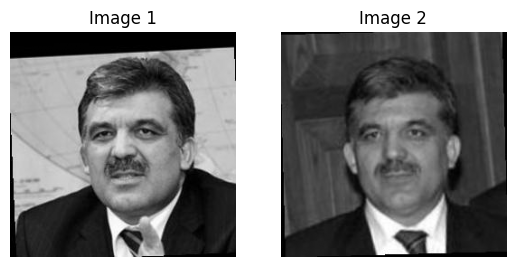

prediction: tensor([[0.2644]], device='cuda:0')
expected result: 1.0


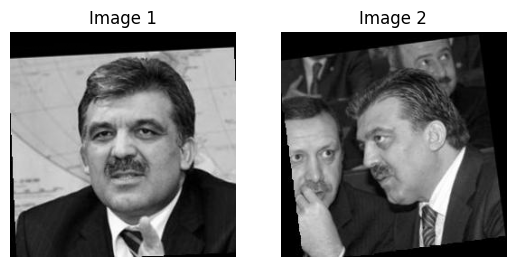

prediction: tensor([[0.2389]], device='cuda:0')
expected result: 1.0


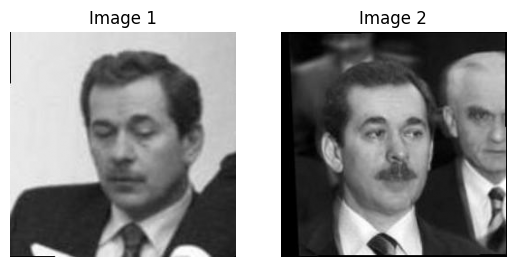

prediction: tensor([[0.4360]], device='cuda:0')
expected result: 1.0


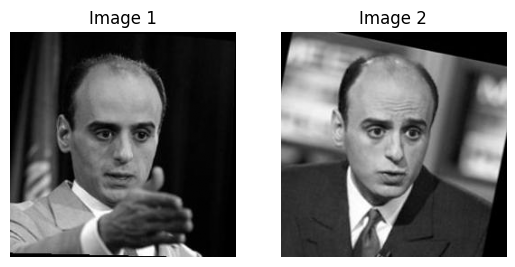

prediction: tensor([[0.5206]], device='cuda:0')
expected result: 1.0


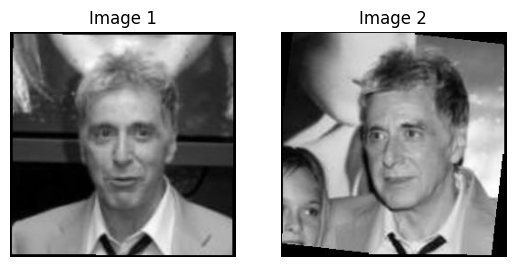

prediction: tensor([[0.5953]], device='cuda:0')
expected result: 1.0


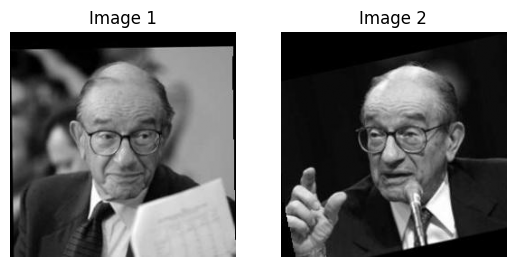

prediction: tensor([[0.6478]], device='cuda:0')
expected result: 1.0


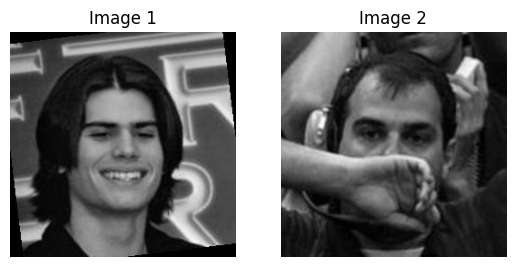

prediction: tensor([[0.1606]], device='cuda:0')
expected result: 0.0


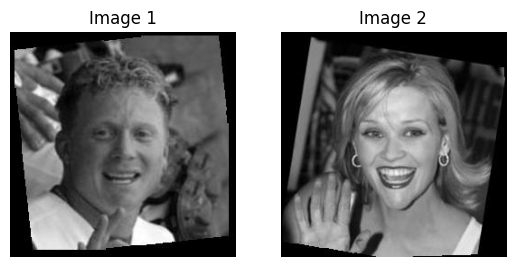

prediction: tensor([[0.5413]], device='cuda:0')
expected result: 0.0


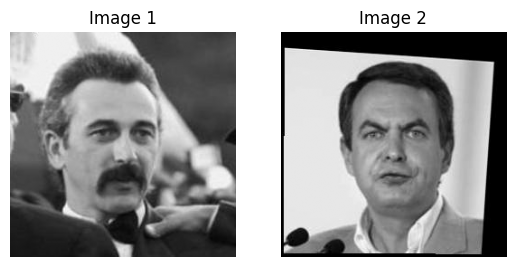

prediction: tensor([[0.4550]], device='cuda:0')
expected result: 0.0


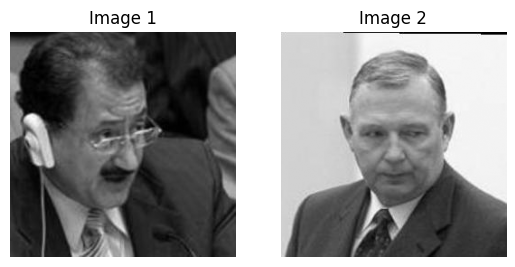

prediction: tensor([[0.4422]], device='cuda:0')
expected result: 0.0


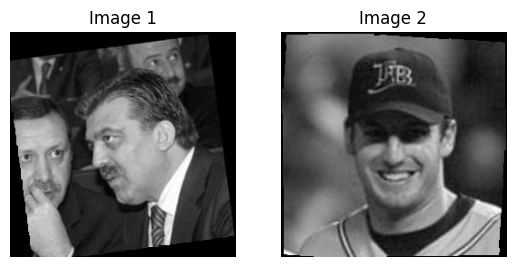

prediction: tensor([[0.5246]], device='cuda:0')
expected result: 0.0


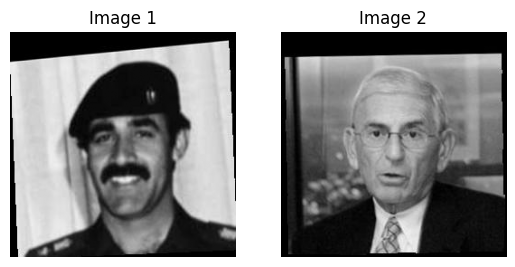

prediction: tensor([[0.3408]], device='cuda:0')
expected result: 0.0
Test Loss: 0.8321, Test Accuracy: 51.00%


In [41]:
import matplotlib.pyplot as plt

# Testing
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

plots_to_open: int = 6
iter_for_same = plots_to_open
iter_for_different = plots_to_open
with torch.no_grad():
    for test_input1, test_input2, test_targets in test_loader:
        test_input1, test_input2, test_targets = \
        test_input1.to(DEVICE_TO_USE, non_blocking=True), \
        test_input2.to(DEVICE_TO_USE, non_blocking=True), \
        test_targets.unsqueeze(1).to(DEVICE_TO_USE, non_blocking=True)


        test_output = model(test_input1, test_input2)

        expected_result = test_targets[0, 0].item()


        if expected_result > 0.9:
            if iter_for_same > 0:

                cpu_input1 = test_input1.cpu()
                cpu_input2 = test_input2.cpu()

                img1_np = cpu_input1[0].squeeze(0).numpy()
                img2_np = cpu_input2[0].squeeze(0).numpy()

                # Plotting
                fig, axs = plt.subplots(1, 2)
                axs[0].imshow(img1_np, cmap='gray')
                axs[0].set_title('Image 1')
                axs[0].axis('off')

                axs[1].imshow(img2_np, cmap='gray')
                axs[1].set_title('Image 2')
                axs[1].axis('off')
                iter_for_same -= 1
                plt.show()
                print(f"prediction: {test_output}")
                print(f"expected result: {expected_result}")
        else:
            if iter_for_different > 0:

                cpu_input1 = test_input1.cpu()
                cpu_input2 = test_input2.cpu()

                img1_np = cpu_input1[0].squeeze(0).numpy()
                img2_np = cpu_input2[0].squeeze(0).numpy()

                # Plotting
                fig, axs = plt.subplots(1, 2)
                axs[0].imshow(img1_np, cmap='gray')
                axs[0].set_title('Image 1')
                axs[0].axis('off')

                axs[1].imshow(img2_np, cmap='gray')
                axs[1].set_title('Image 2')
                axs[1].axis('off')
                iter_for_different -= 1
                plt.show()
                print(f"prediction: {test_output}")
                print(f"expected result: {expected_result}")

        batch_loss = criterion(test_output, test_targets)
        test_loss += batch_loss.item()
        predictions = torch.sigmoid(test_output) > 0.5
        correct = (predictions.float() == test_targets).sum().item()
        correct_predictions += correct
        total_predictions += test_targets.size(0)


test_loss /= len(test_loader)
accuracy = correct_predictions / total_predictions

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")